In [1]:
import pandas as pd
import re
import numpy as np
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import os
import tensorflow as tf
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import string
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
#Acquire the dataset from AllReviews csv file and clean it up to a usable form
AllReviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AllReviews.csv')
AllReviews = AllReviews.loc[(AllReviews["titleType"] == "tvMovie")|(AllReviews["titleType"] == "movie")]

# Filter relevant columns and remove duplicates
Reviews_Genres_Title = AllReviews[["Review", "genres"]].drop_duplicates()
# Remove rows with missing reviews
Reviews_Genres_Title = Reviews_Genres_Title.dropna(subset=["Review"])
# Remove rows with undefined genres
Reviews_Genres_Title = Reviews_Genres_Title[Reviews_Genres_Title["genres"] != '\\N']

# Copy for further processing
Complete_Reviews = Reviews_Genres_Title.copy()
# Convert reviews to lowercase
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.lower()
# Replace periods and commas
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('[,.]', ' ', regex=True)
# Remove newlines
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('\n', '', regex=False)
# Remove HTML tags
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('<[^>]+>', '', regex=True)
# Remove non-alphanumeric characters
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('[^A-Za-z0-9 ]+', '', regex=True)
Complete_Reviews.reset_index(drop=True, inplace=True)

In [5]:
# DistilGPT2 pretrained
New_Reviews = pd.read_csv('/content/drive/MyDrive/results/distilgpt_reviews.csv')
## DistilGPT2 finetuned
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/distilgpt_finetuned_reviews.csv')


# Remove Prompt
New_Reviews['review'] = New_Reviews['review'].str.replace('^write a movie review:', '', regex=True)
# Convert reviews to lowercase
New_Reviews['review'] = New_Reviews['review'].str.lower()
# Replace periods and commas
New_Reviews['review'] = New_Reviews['review'].str.replace('[,.]', ' ', regex=True)
# Remove newlines
New_Reviews['review'] = New_Reviews['review'].str.replace('\n', '', regex=False)
# Remove HTML tags
New_Reviews['review'] = New_Reviews['review'].str.replace('<[^>]+>', '', regex=True)
# Remove non-alphanumeric characters
New_Reviews['review'] = New_Reviews['review'].str.replace('[^A-Za-z0-9 ]+', '', regex=True)

fake_reviews = pd.DataFrame({'Review': New_Reviews['review'], 'Label': 'fake'})

In [6]:
# Randomly select an equal number of real reviews for classification training
points = np.random.choice(list(range(Complete_Reviews.shape[0])), size = fake_reviews.shape[0], replace = False)
real_reviews = Complete_Reviews['Review'][points]
real_reviews = pd.DataFrame({'Review': real_reviews, 'Label': 'real'})

In [7]:
reviews = pd.concat([real_reviews, fake_reviews]).reset_index(drop=True)
reviews = reviews.sample(frac=1, random_state=42).reset_index(drop=True)
reviews

,Review,Label
0,of i that is of to the of who the is of of wh...,fake
1,if there is a movie to be called perfect then ...,real
2,if you thought herbie trying to kill himself b...,real
3,hey guys i have been looking every where to f...,real
4,marisa and regina turn is great performances a...,real
...,...,...
9995,i a to the movie i not this had great seen m...,fake
9996,movie review review spoiler i the movie is of...,fake
9997,im to you this is worst ever i what waste tim...,fake
9998,connie selleca whose acting rivals that of al...,real


In [8]:
all_data = reviews['Review']
all_labels = reviews['Label']

split_point = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, train_size = split_point)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [9]:
def get_mlp_classifier(train_data, train_labels, **kwargs):
  model = make_pipeline(TfidfVectorizer(), MLPClassifier(**kwargs))
  model.fit(train_data, train_labels)
  return model

model = get_mlp_classifier(X_train, y_train, hidden_layer_sizes = (100,), verbose = True)

Iteration 1, loss = 0.49244711
Iteration 2, loss = 0.16930367
Iteration 3, loss = 0.06086841
Iteration 4, loss = 0.03025424
Iteration 5, loss = 0.01860323
Iteration 6, loss = 0.01282389
Iteration 7, loss = 0.00953509
Iteration 8, loss = 0.00742754
Iteration 9, loss = 0.00602450
Iteration 10, loss = 0.00501826
Iteration 11, loss = 0.00429153
Iteration 12, loss = 0.00373525
Iteration 13, loss = 0.00330694
Iteration 14, loss = 0.00297080
Iteration 15, loss = 0.00269402
Iteration 16, loss = 0.00247275
Iteration 17, loss = 0.00228663
Iteration 18, loss = 0.00213169
Iteration 19, loss = 0.00199932
Iteration 20, loss = 0.00188588
Iteration 21, loss = 0.00179006
Iteration 22, loss = 0.00170355
Iteration 23, loss = 0.00162928
Iteration 24, loss = 0.00156343
Iteration 25, loss = 0.00150378
Iteration 26, loss = 0.00145035
Iteration 27, loss = 0.00140297
Iteration 28, loss = 0.00135921
Iteration 29, loss = 0.00131963
Iteration 30, loss = 0.00128376
Iteration 31, loss = 0.00124982
Training loss did

In [10]:
y_pred = model.predict(X_test)

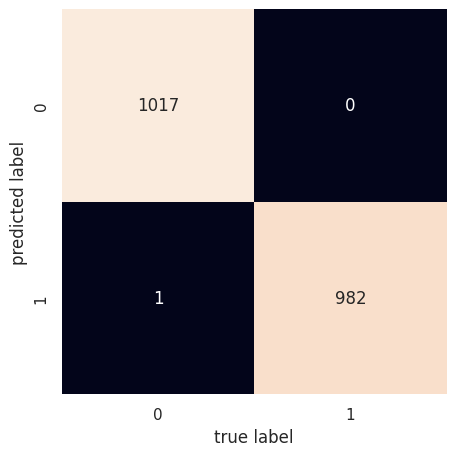

In [11]:
def get_confusion_matrix(test_labels, pred_labels):
    sns.set()
    mat = confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

get_confusion_matrix(y_test, y_pred)

In [12]:
def get_f1_scores(test_labels, pred_labels):
    f1 = f1_score(test_labels, pred_labels, pos_label = 'real')
    print("F1 Score:", round(100*f1, 2), "%")

get_f1_scores(y_test, y_pred)

F1 Score: 99.95 %


In [ ]:
model = get_mlp_classifier(X_train, y_train, hidden_layer_sizes = (100, 100), learning_rate = 'adaptive', verbose = True)
y_pred = model.predict(X_test)
get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)

In [14]:
# The embed model is loaded from Google Drive
glove2word2vec('/content/drive/MyDrive/results/glove.6B.300d.txt', '/content/drive/MyDrive/results/glove.6B.300d.word2vec.txt')
embed_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/results/glove.6B.300d.word2vec.txt')

<ipython-input-14-06e4a87da033>:2: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec('/content/drive/MyDrive/results/glove.6B.300d.txt', '/content/drive/MyDrive/results/glove.6B.300d.word2vec.txt')


In [15]:
# The function was edited to use OOV_embed as a global variable instead of a parameter, so the list comprehension can work
def calc_doc_embedding(doc, embed_model, embed_size):
    global OOV_embed
    doc = doc.lower()
    stopset = set(stopwords.words('english') + list(string.punctuation))
    rwords = doc.split()
    rwords = list(set(rwords) - set(stopset))
    missing_words = [rword for rword in rwords if not embed_model.has_index_for(rword)]
    present_words = list(set(rwords) - set(missing_words))
    for missing_word in missing_words:
        if missing_word in OOV_embed:
            continue
        fill_in = np.random.randint(0, len(embed_model.vectors))
        OOV_embed[missing_word] = embed_model.vectors[fill_in]
    doc_embed1 = np.sum([embed_model.get_vector(rword) for rword in present_words], axis = 0)
    doc_embed2 = np.sum([OOV_embed[rword] for rword in missing_words], axis = 0)
    doc_embed = (doc_embed1 + doc_embed2)/len(rwords)
    return doc_embed

In [16]:
OOV_embed = {}
X_train_embed = np.vstack([calc_doc_embedding(doc, embed_model, 100) for doc in X_train])
X_test_embed = np.vstack([calc_doc_embedding(doc, embed_model, 100) for doc in X_test])

In [19]:
# 4 hidden layers with 400 units each
def get_mlp_classifier_embed(train_data_embed, train_labels, **kwargs):
  model = MLPClassifier(**kwargs)
  model.fit(train_data_embed, train_labels)
  return model

model = get_mlp_classifier_embed(X_train_embed, y_train, hidden_layer_sizes = (100, 100, 100, 100), learning_rate = 'adaptive', verbose = True)

Iteration 1, loss = 0.30557047
Iteration 2, loss = 0.04631316
Iteration 3, loss = 0.02196400
Iteration 4, loss = 0.01573241
Iteration 5, loss = 0.01015894
Iteration 6, loss = 0.00531620
Iteration 7, loss = 0.00307667
Iteration 8, loss = 0.00179192
Iteration 9, loss = 0.00102025
Iteration 10, loss = 0.00084067
Iteration 11, loss = 0.00056188
Iteration 12, loss = 0.00036652
Iteration 13, loss = 0.00035374
Iteration 14, loss = 0.00025281
Iteration 15, loss = 0.00023402
Iteration 16, loss = 0.00019840
Iteration 17, loss = 0.00017493
Iteration 18, loss = 0.00015964
Iteration 19, loss = 0.00015014
Iteration 20, loss = 0.00013919
Iteration 21, loss = 0.00013300
Iteration 22, loss = 0.00012839
Iteration 23, loss = 0.00012461
Iteration 24, loss = 0.00012209
Iteration 25, loss = 0.00011996
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


F1 Score: 99.19 %


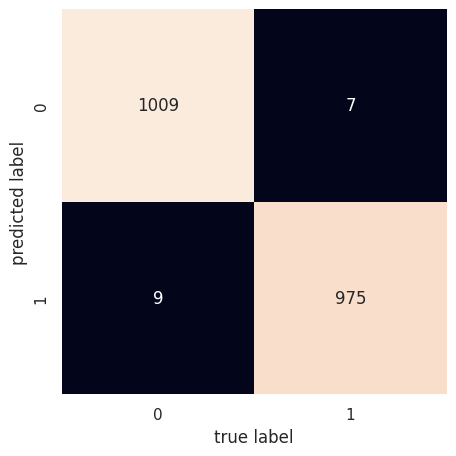

In [20]:
y_pred = model.predict(X_test_embed)
get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)

In [21]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder().fit(all_labels)
y_train_num = le.transform(y_train)
y_test_num = le.transform(y_test)

In [23]:
train_tensor = tf.data.Dataset.from_tensor_slices((X_train, y_train_num))

test_tensor = tf.data.Dataset.from_tensor_slices((X_test, y_test_num))

In [24]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_tensor = train_tensor.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_tensor = test_tensor.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 50000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_tensor.map(lambda text, label: text))

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_tensor, epochs=10,
                    validation_data=test_tensor,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_tensor)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/10
125/125 [==============================] - 262s 2s/step - loss: 1.3783 - accuracy: 0.5585 - val_loss: 0.6841 - val_accuracy: 0.6354
Epoch 2/10
125/125 [==============================] - 227s 2s/step - loss: 0.5112 - accuracy: 0.8185 - val_loss: 0.1520 - val_accuracy: 0.9776
Epoch 3/10
125/125 [==============================] - 227s 2s/step - loss: 0.3294 - accuracy: 0.8584 - val_loss: 0.1015 - val_accuracy: 0.9870
Epoch 4/10
125/125 [==============================] - 226s 2s/step - loss: 0.0596 - accuracy: 0.9915 - val_loss: 0.0360 - val_accuracy: 0.9948
Epoch 5/10
125/125 [==============================] - 238s 2s/step - loss: 0.0348 - accuracy: 0.9930 - val_loss: 0.0268 - val_accuracy: 0.9958
Epoch 6/10
125/125 [==============================] - 224s 2s/step - loss: 0.0204 - accuracy: 0.9954 - val_loss: 0.0276 - val_accuracy: 0.9896
Epoch 7/10
125/125 [==============================] - 229s 2s/step - loss: 0.0133 - accuracy: 0.9977 - val_loss: 0.0185 - val_accuracy: 0.9958

In [27]:
y_pred_num = model.predict(test_tensor)
y_pred = [le.classes_[np.argmax(x)] for x in y_pred_num]

32/32 [==============================] - 15s 324ms/step


F1 Score: 99.29 %


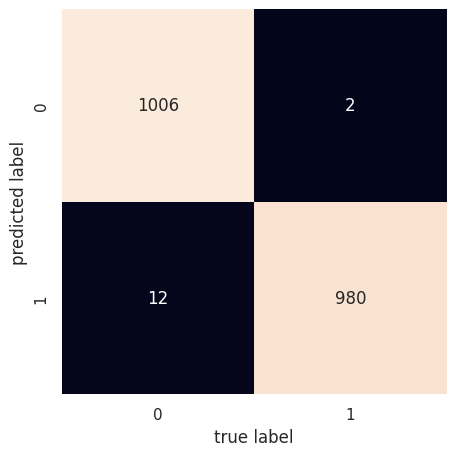

In [28]:
get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)